Hi, Marcel! 

Hope it'll help you to run my code quicker :)

Alex

## Input format

| ID |     Name    | FA_Name | Value |
|---:|:-----------:|:-------:|-------|
|  1 | Revenue_123 | Revenue | -100  |
where **ID** - is actual Business Processes ID, **Name** is the full name of FinancialAccount (not sure that it's required, but initially as I guess one has something like "Revenue_1", "Revenue_2" for different product and only after application of Coarse-graining financial accounts we are getting **FA_Name** value. **Value** is just a amount.
## Extraction signatures of BP
For that purpose I've implemented aggregation function over *groupby()* object, as input it uses one BP – a part of original DF with the same ID value – and return a string like
```
'([(\\'Revenue\\', 0.8336558167088283), (\\'Tax\\', 0.1663441832911717)], [(\\'TradeReceivables\\', 1.0)])'
```
then we leave only unique signatures (SAME FA from left and right part AND EXACTLY EQUAL coefficients).
## Data preprocessing
Then on that DataFrame you need to apply [*prepare_data()*](https://github.com/AlexWorldD/NetEmbs/blob/master/NetEmbs/DataProcessing/prepare_data.py) - please read the documentation to that function. The last thing I've added is 
```
 :param unique: True if Data has to be filtered wrt to Signatures of BPs
 ```

After that you should get the following structure:

| ID |     Name    | FA_Name | Value | Debit | Credit | from |
|---:|:-----------:|:-------:|-------|-------|--------|------|
|  1 | Revenue_123 | Revenue | -100  | 0.0   | 1.0    | True |

here **from** is for visualization purposes only (different colors of ingoing/outgoing edges)
## Construct FSN
Now we can construct FSN from our DataFrame, *build()* method of *FSN* class. 

I recommend to check the construction via *get_FA()* method, it should return the set of Financial Account nodes.
## RandomWalks
#### Already implemented step strategies
1. Pure RandomWalk (uniform probabilities, follows the direction)
2. MetaDef (change directions, uniform probabilities)
3. MetaDefWeighted (change directions, weighted probabilities "rich gets richer")
4. MetaDiff (change directions, probabilities depend on the differences between edges)

For test purpose you can try *randomWalk()* from NetEmbs.FSN.utils, it returns the sampled sequence. 

**BUT**, I've implemented special helper funciton for adding to original DataFrame a column with N top joint-appearance nodes. It's *add_similar()* function from NetEmbs.FSN.utils.

You also can test it with different step strategies: "DefUniform", "DefWeighted", "MetaUniform", "MetaWeighted", "MetaDiff" (version argument).

### Example with sampled data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.DataProcessing.connect_db import *
from NetEmbs.GenerateData.complex_df import sales_collections
d = upload_data("Simulation/FSN_Data.db", limit=100)
d.head(5)

,ID,Name,FA_Name,Value
0,1,Revenue_2,Revenue,-921.000000
1,1,Tax_2,Tax,-193.731819
2,1,TradeReceivables_2,TradeReceivables,1114.731819
3,2,opwdiu_3,opwdiu,-8.052642
4,2,eucdcj_3,eucdcj,8.037404


## Data Simulation: Statistics

In [162]:
sim_d = prepare_data(upload_data("Simulation/FSN_Data.db", None))
sim_d.head(2)

,ID,Signature,FA_Name,Debit,Credit,from
0,1,"([('TradePayables', 1.0)], [('FixedAssets', 0.99133), ('slmtpi', 0.00795), ('sppzzl', 0.00073)])",FixedAssets,0.991327,0.0,False
1,1,"([('TradePayables', 1.0)], [('FixedAssets', 0.99133), ('slmtpi', 0.00795), ('sppzzl', 0.00073)])",TradePayables,0.000000,1.0,True


In [154]:
sim_d.groupby("ID").apply(get_left_right)

,Left,Right
ID,,
1,2,1
2,1,1
9,1,1
10,2,1
16,2,1
19,1,1
22,1,1
23,1,1
41,3,1


In [163]:
import pandas as pd
from collections import Counter


def get_left_right(df):
    """
    Helper function for counting left-hand and right-hand account for BP
    :param df: grouped object
    :return: Series with number of FA on the left side and on the right side
    """
    return pd.Series({"Left": df[df["from"] == True].count()[0], "Right": df[df["from"] == False].count()[0]})


def getHistCounts(df):
    stat_here = df.groupby("ID", as_index=False).apply(get_left_right)
    res = dict()
    for n in list(stat_here):
        res[n] = Counter(stat_here[n])
    return res

def plotHist(df, title="Histogram"):
    stat_here = getHistCounts(df)
    from matplotlib.ticker import MaxNLocator
    for k, d in stat_here.items():
        ax = plt.figure().gca()
        ax.bar(d.keys(), d.values())
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(k + "-side number of FAs")
        if title is not None and isinstance(title, str):
            plt.tight_layout()
            plt.savefig("img/" + title + k, dpi=140, pad_inches=0.01)

In [147]:
stat_here = getHistCounts(sim_d)

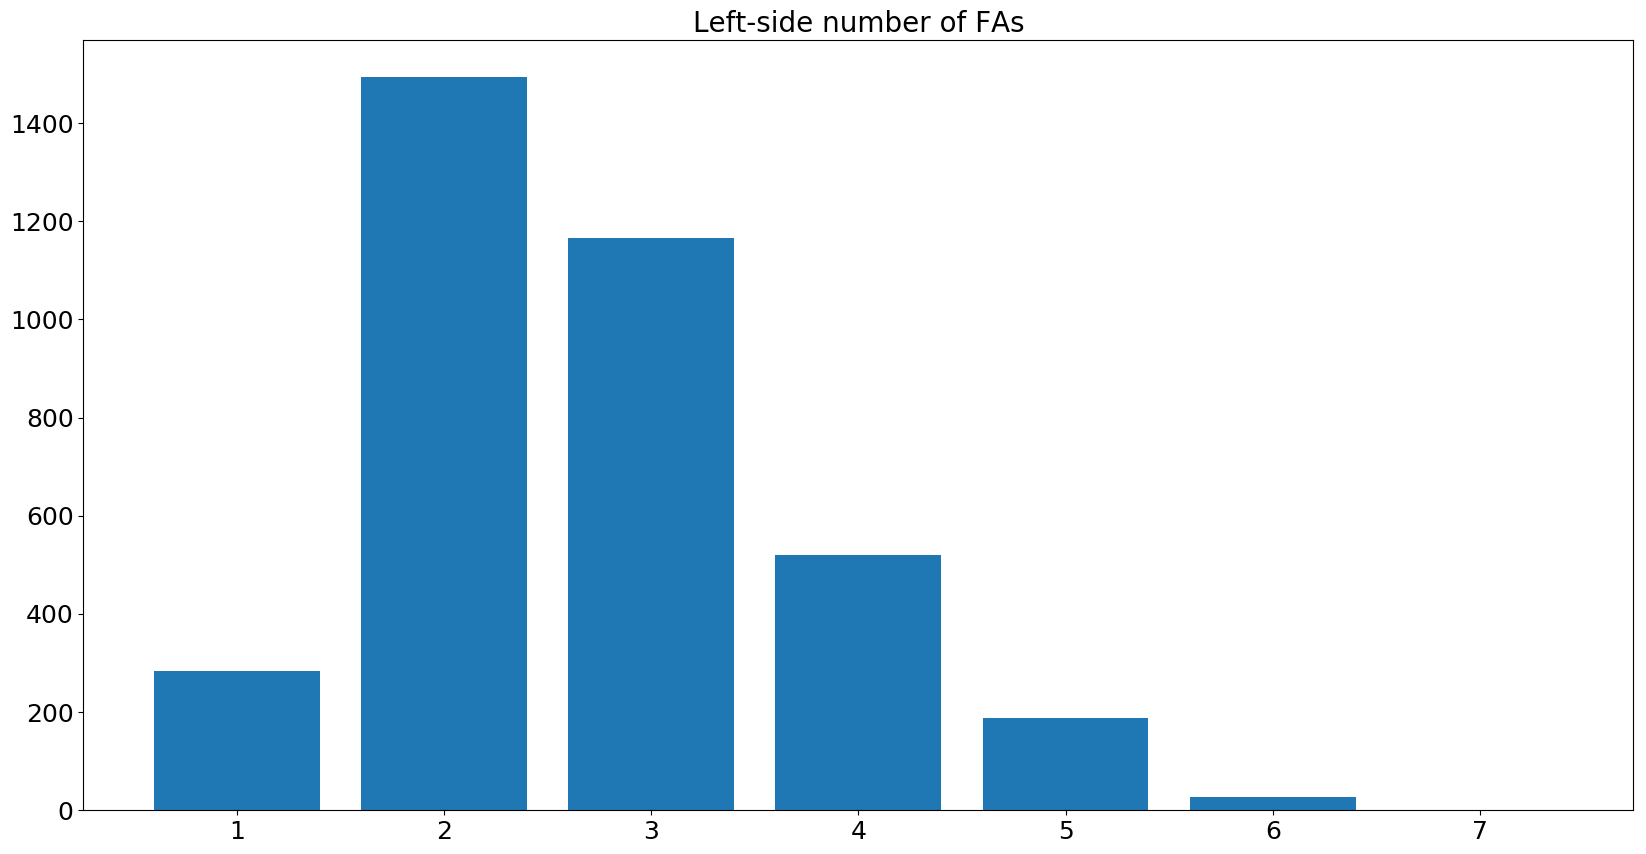

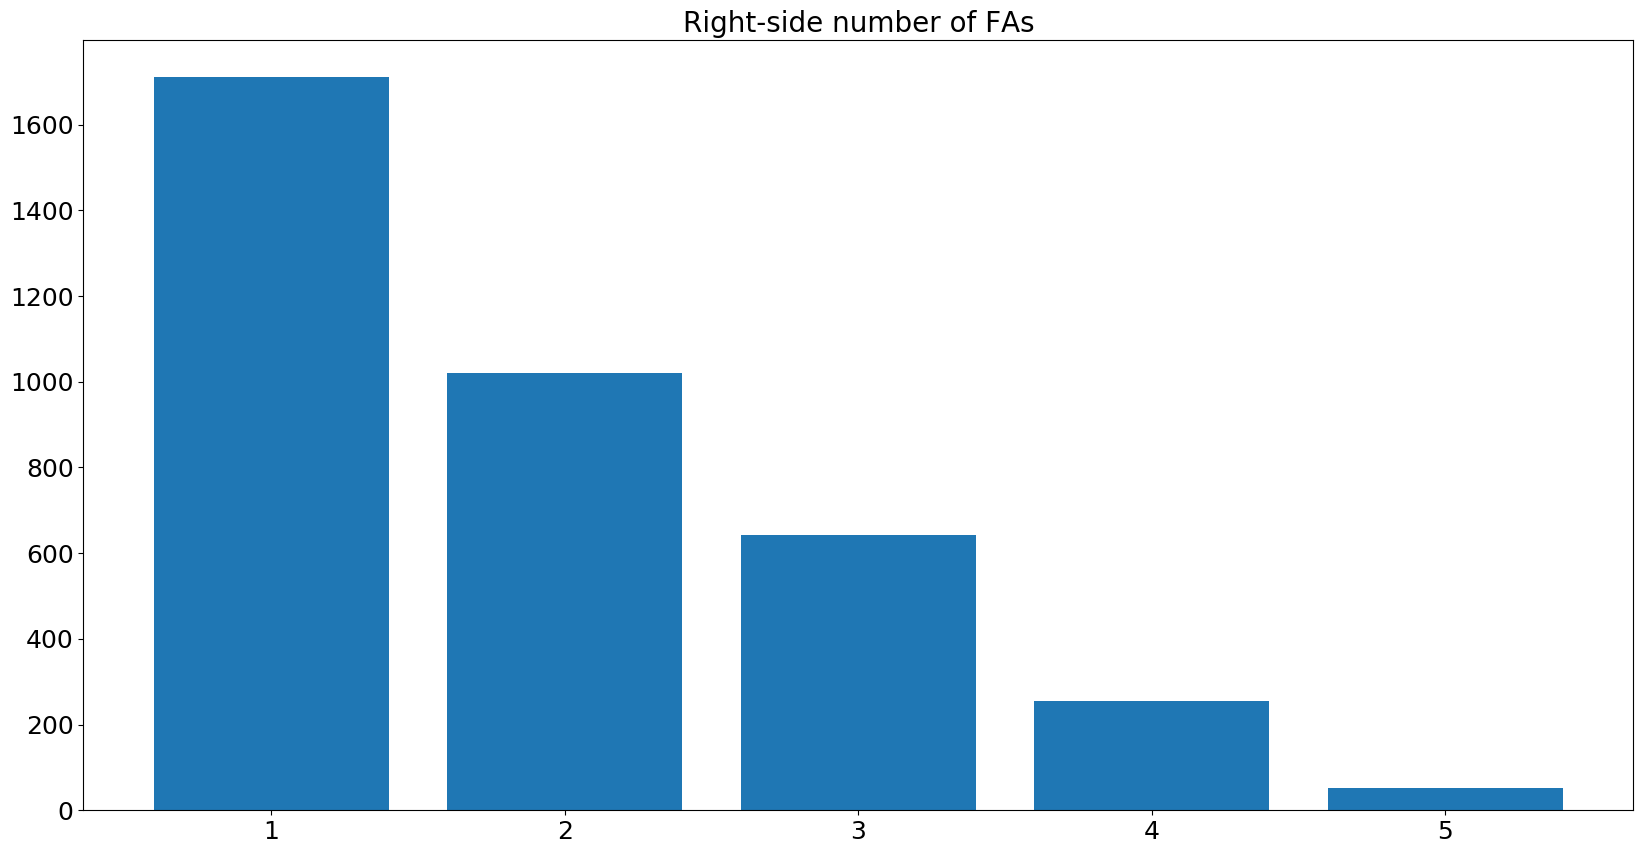

In [164]:
plotHist(sim_d, None)

### Marcel, below you can test your input format, it should work correctly

Taking into account that real data already has two columns with debited and credited amounts, for preprocessing it you need to apply sequentially 

*rename_columns()*

with default arguments it's fit for your column titles and then 

*prepare_data(..., split=False)*

In [3]:
from NetEmbs.DataProcessing import *
journal_entries = None
if journal_entries is None:
    d = prepare_data(d)
else:
    YOUR_DATAFRAME = pd.DataFrame.from_dict(journal_entries)
    YOUR_DATAFRAME.columns = ['ID', 'FA_Name', 'Debit', 'Credit']
    d = prepare_data(YOUR_DATAFRAME, split=False)
d.head(20)

,ID,Signature,FA_Name,Debit,Credit,from
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Revenue,0.000000,0.826208,True
1,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Tax,0.000000,0.173792,True
2,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",TradeReceivables,1.000000,0.000000,False
3,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",CostOfSales,0.991273,0.000000,False
4,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",Inventory,0.000000,0.985881,True
5,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",balzki,0.000000,0.005376,True
6,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",eucdcj,0.008727,0.000000,False
7,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",opwdiu,0.000000,0.008743,True
8,3,"([('Cash', 1.0)], [('Tax', 1.0)])",Cash,0.000000,1.000000,True
9,3,"([('Cash', 1.0)], [('Tax', 1.0)])",Tax,1.000000,0.000000,False


In [12]:
for k, group in d.groupby("ID"):
    if group.shape[0]>6:
        group.to_excel("ex.xlsx")

In [4]:
from NetEmbs.FSN.graph import FSN
fsn = FSN()
fsn.build(d, name_column="FA_Name")
fsn.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 21, 22, 24, 27, 29, 'Revenue', 'Tax', 'TradeReceivables', 'CostOfSales', 'Inventory', 'balzki', 'eucdcj', 'opwdiu', 'Cash', 'EBPayables', 'PersonnelExpenses', 'sxnkol', 'uzbcge', 'vbzovt', 'devoji', 'diajgb', 'FixedAssets', 'TradePayables', 'emdmug', 'OtherExpenses', 'PrepaidExpenses', 'dqiihn', 'epbcyx', 'uzvqin', 'DepreciationExpense', 'izolmo', 'kaxwdy', 'nfpqhp', 'zupdhg', 'bzxaqi', 'fgftgk', 'gdsgne', 'woeqep', 'irmzan', 'swxmeh', 'uvdxts', 'yluoun', 'fgnsst', 'ndznzg', 'qeclna', 'qjnldx'))

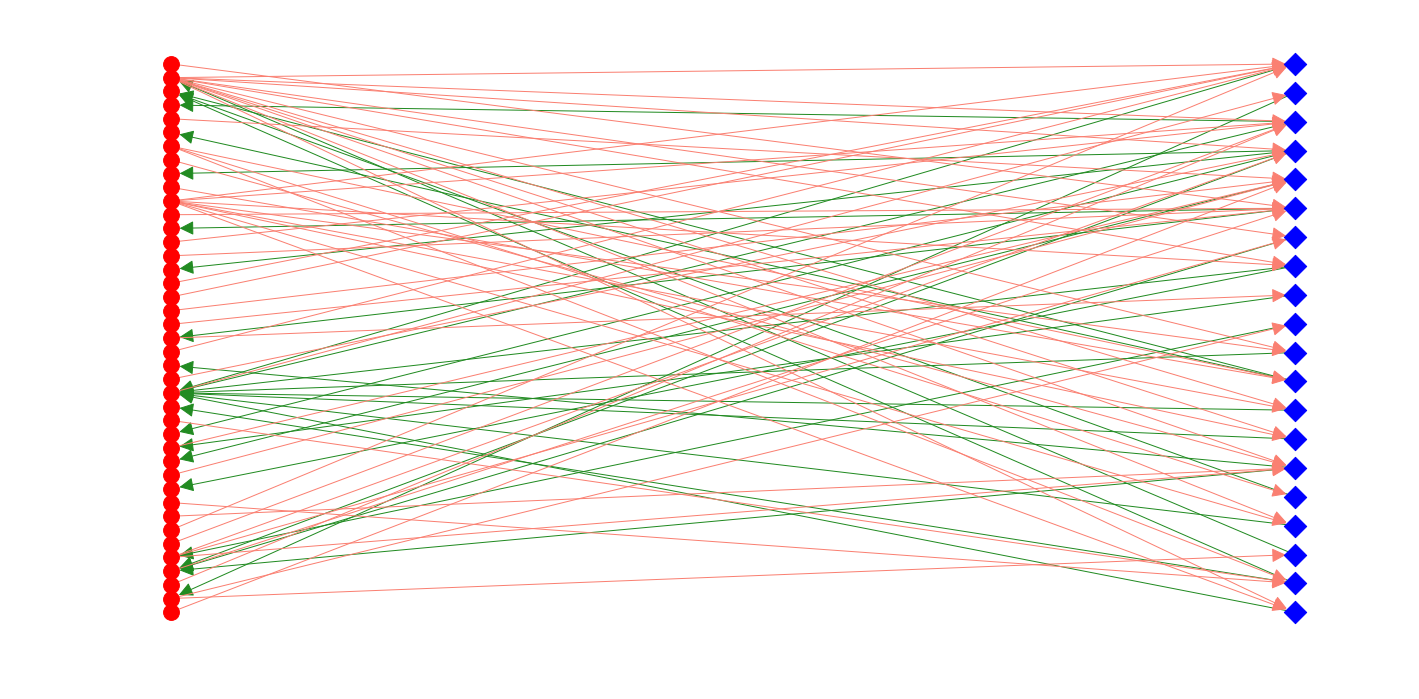

In [5]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn, edge_labels=False, node_labels=False, title="Img2")

In [6]:
from NetEmbs.FSN.utils import add_similar, get_pairs
add_similar(d, direction="COMBI").head(5)

,ID,Signature,FA_Name,Debit,Credit,from,Similar_BP
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Revenue,0.000000,0.826208,True,"[(9, 89), (11, 79), (24, 69)]"
1,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",Tax,0.000000,0.173792,True,"[(9, 89), (11, 79), (24, 69)]"
2,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('...",TradeReceivables,1.000000,0.000000,False,"[(9, 89), (11, 79), (24, 69)]"
3,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",CostOfSales,0.991273,0.000000,False,"[(5, 196), (10, 153)]"
4,2,"([('Inventory', 0.98588), ('balzki', 0.00538),...",Inventory,0.000000,0.985881,True,"[(5, 196), (10, 153)]"


## Testing different Pairs construction

In [ ]:
from NetEmbs.FSN import *
randomWalk(fsn, 1, length=10, direction="COMBI")

In [ ]:
list(fsn.successors(7)), list(fsn.predecessors(7))

In [ ]:
d["ID"].unique()

In [6]:
from NetEmbs.FSN.utils import similar
from NetEmbs.Logs.custom_logger import log_me
pd.set_option('display.max_colwidth', -1)
MAIN_LOGGER = log_me()
MAIN_LOGGER.info("Started..")
d = prepare_data(upload_data("Simulation/FSN_Data.db", limit=200))
similar(d, direction=["COMBI"]).head(15)

Done with extraction Journal Entries data!
Done with RandomWalking... Found  3  top


,ID,Signature,MetaDiff_COMBI
0,1,"([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82672), ('Tax', 0.17328)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.94355), ('Tax', 0.05645)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------]"
1,2,"([('Inventory', 0.98588), ('balzki', 0.00538), ('opwdiu', 0.00874)], [('CostOfSales', 0.99127), ('eucdcj', 0.00873)])","[([('Inventory', 0.99095), ('kaljas', 0.00311), ('lxohur', 0.00351), ('rmntvs', 0.00244)], [('CostOfSales', 0.99462), ('llkees', 0.00538)]), ---------, ([('Inventory', 0.99333), ('hfjpzp', 0.00667)], [('CostOfSales', 0.99001), ('ddublc', 0.00552), ('jvwxot', 0.00447)]), ---------, ([('Inventory', 0.9944), ('devoji', 0.0056)], [('CostOfSales', 0.99902), ('diajgb', 0.00098)]), ---------]"
2,3,"([('Cash', 1.0)], [('Tax', 1.0)])","[([('Cash', 1.0)], [('EBPayables', 1.0)]), ---------]"
3,4,"([('Revenue', 0.9434), ('Tax', 0.0566)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.94355), ('Tax', 0.05645)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.94383), ('Tax', 0.05617)], [('TradeReceivables', 0.99176), ('emdmug', 0.00824)]), ---------, ([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------]"
4,5,"([('Inventory', 1.0)], [('CostOfSales', 1.0)])","[([('Inventory', 0.9944), ('devoji', 0.0056)], [('CostOfSales', 0.99902), ('diajgb', 0.00098)]), ---------, ([('Inventory', 0.9826), ('hkdbrq', 0.00441), ('nmmjft', 0.00397), ('vkraxy', 0.00901)], [('CostOfSales', 1.0)]), ---------, ([('Inventory', 0.99095), ('kaljas', 0.00311), ('lxohur', 0.00351), ('rmntvs', 0.00244)], [('CostOfSales', 0.99462), ('llkees', 0.00538)]), ---------]"
5,6,"([('EBPayables', 0.78677), ('Tax', 0.21), ('uzbcge', 0.0018), ('vbzovt', 0.00143)], [('PersonnelExpenses', 0.99963), ('sxnkol', 0.00037)])","[([('EBPayables', 0.79), ('Tax', 0.21)], [('PersonnelExpenses', 1.0)]), ---------, ([('EBPayables', 0.78975), ('Tax', 0.21), ('gdsgne', 0.00025)], [('PersonnelExpenses', 0.99649), ('bzxaqi', 0.00207), ('fgftgk', 0.00087), ('woeqep', 0.00057)]), ---------, ([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)]), ---------]"
6,7,"([('Revenue', 0.82745), ('Tax', 0.17255)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------, ([('Revenue', 0.94355), ('Tax', 0.05645)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)]), ---------]"
7,9,"([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.94355), ('Tax', 0.05645)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82621), ('Tax', 0.17379)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------]"
8,10,"([('Inventory', 0.9944), ('devoji', 0.0056)], [('CostOfSales', 0.99902), ('diajgb', 0.00098)])","[([('Inventory', 0.9826), ('hkdbrq', 0.00441), ('nmmjft', 0.00397), ('vkraxy', 0.00901)], [('CostOfSales', 1.0)]), ---------, ([('Inventory', 1.0)], [('CostOfSales', 1.0)]), ---------, ([('Inventory', 0.98588), ('balzki', 0.00538), ('opwdiu', 0.00874)], [('CostOfSales', 0.99127), ('eucdcj', 0.00873)]), ---------]"
9,11,"([('Revenue', 0.82525), ('Tax', 0.17475)], [('TradeReceivables', 1.0)])","[([('Revenue', 0.82302), ('Tax', 0.17131), ('cewfdm', 0.00567)], [('TradeReceivables', 0.98961), ('cdwyug', 0.00643), ('deesvq', 0.00396)]), ---------, ([('Revenue', 0.82672), ('Tax', 0.17328)], [('TradeReceivables', 1.0)]), ---------, ([('Revenue', 0.82775), ('Tax', 0.17225)], [('TradeReceivables', 1.0)]), ---

## Tests

In [ ]:
from NetEmbs.FSN.utils import make_pairs
t = [1,2,3,1,2]
out = make_pairs(t, window=2)
out

# Skip-Gram model
Previously we've gotten a list of tuples where the first item is input word in term of Skip-gram model and the second item is output word. Hence, one can implement the simplest skip-gram model over it.

In [8]:
from NetEmbs.FSN.utils import *
skip_grams, fsn, enc_dec = get_SkipGrams(d)
skip_grams[:5]

[(0, 7), (0, 21), (0, 19), (7, 0), (7, 21)]

### Batch function

In [10]:
def generate_batch(all_data, batch_size):
    _t = np.random.randint(0, len(all_data), batch_size)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32, buffer=np.array([all_data[t][0] for t in _t]))
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32, buffer=np.array([all_data[t][1] for t in _t]))
    return batch, context

In [10]:
generate_batch(skip_grams[:100], 3)

(array([19,  0, 21], dtype=int32), array([[0],
        [0],
        [9]], dtype=int32))

### TensorFlow

In [7]:
from NetEmbs.SkipGram import *
import seaborn as sns

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

res = get_embs_TF(path_file="Simulation/FSN_Data.db", embed_size=8)

[(0, 66), (0, 27), (0, 9), (66, 0), (66, 27)]
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Initialized
Average train loss at step  0 :  3.149240493774414
Nearest to 92: 95, 136, 156,
Nearest to 161: 80, 147, 137,
Nearest to 52: 166, 156, 22,
Nearest to 47: 115, 98, 18,
Average train loss at step  1000 :  0.910186801224947
Average train loss at step  2000 :  0.4696228004097939
Average train loss at step  3000 :  0.38347413432598115
Average train loss at step  4000 :  0.30638876649737357
Average train loss at step  5000 :  0.27679211284965277
Nearest to 92: 63, 42, 21,
Nearest to 161: 89, 154, 9,
Nearest to 52: 102, 55, 75,
Nearest to 47: 95, 79, 33,
Average train loss at step  6000 :  0.2621425400525331
Average train loss at step  7000 :  0.25461990417540076
Average train loss at step  8000 :  0.2539072055742145
Average train loss at step  9000 :  0.2479662085697055
Average train loss at step  10000 :  0.24534328889846801
Nearest to 

Collections


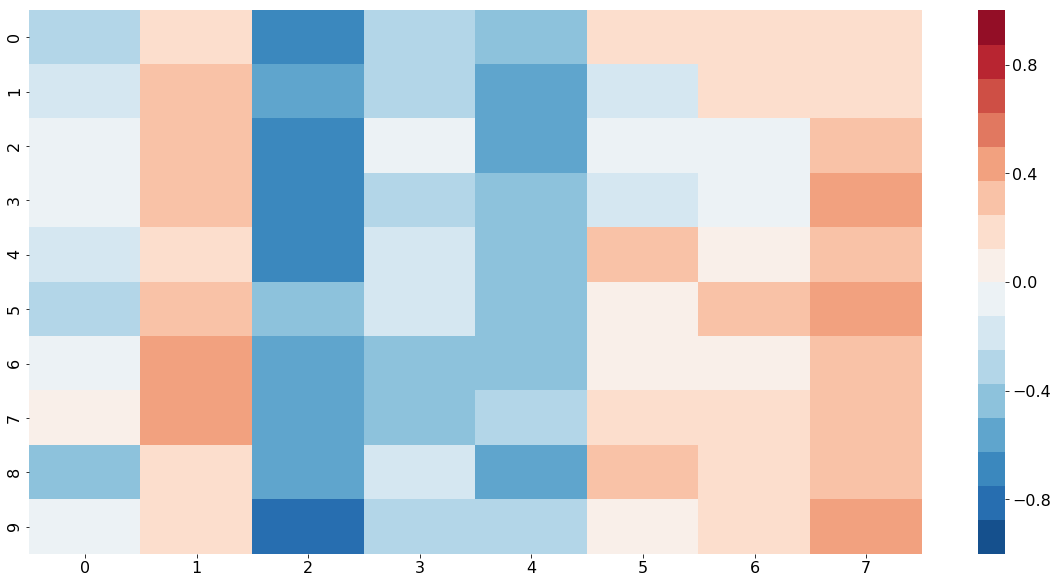

Cost of Sales


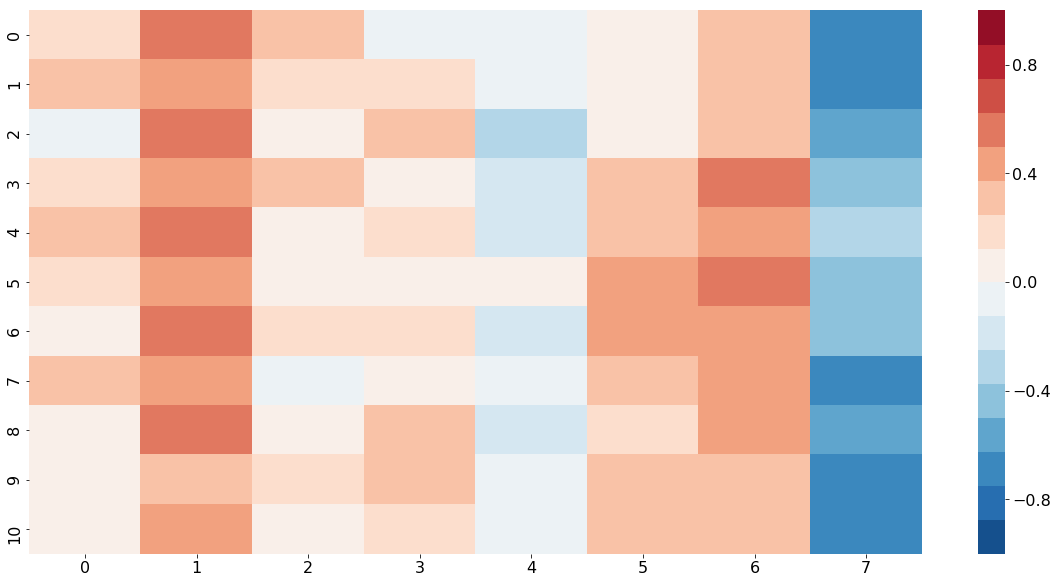

Depreciation


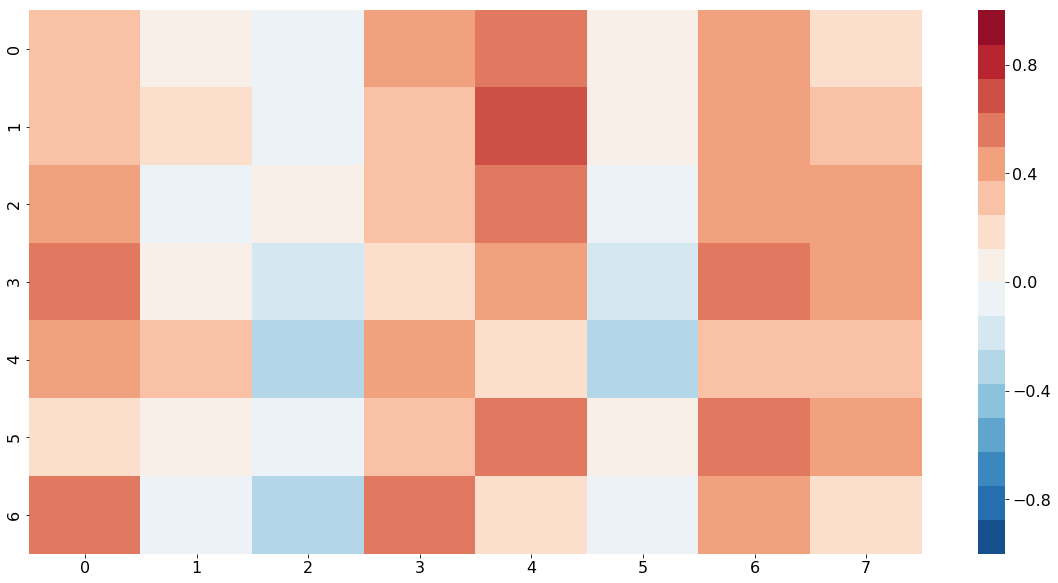

Fixed Assets
Not enough samples...
Payroll


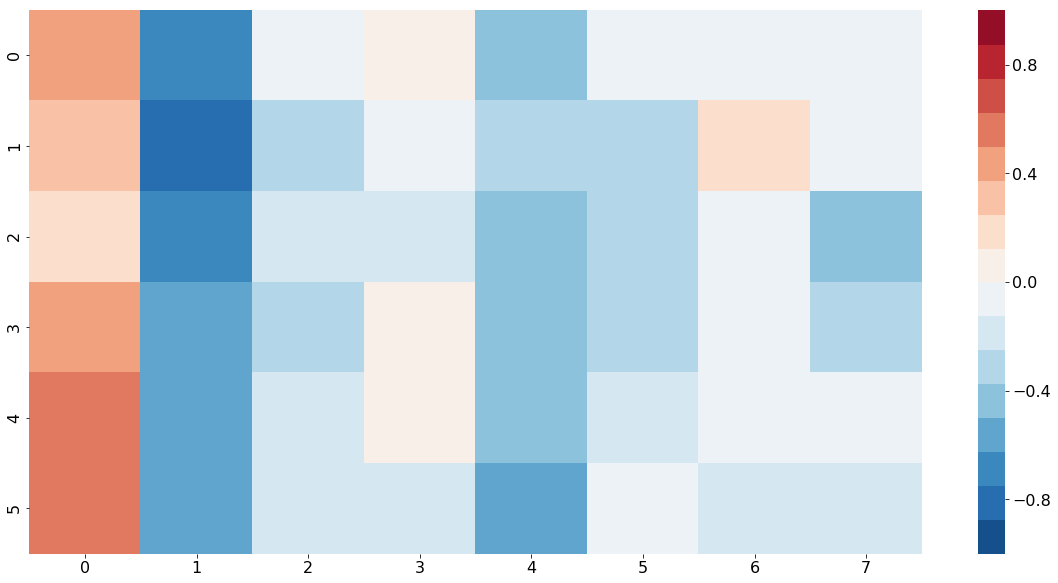

Payroll Disbursement
Not enough samples...
Purchase
Not enough samples...
Sales 21 btw


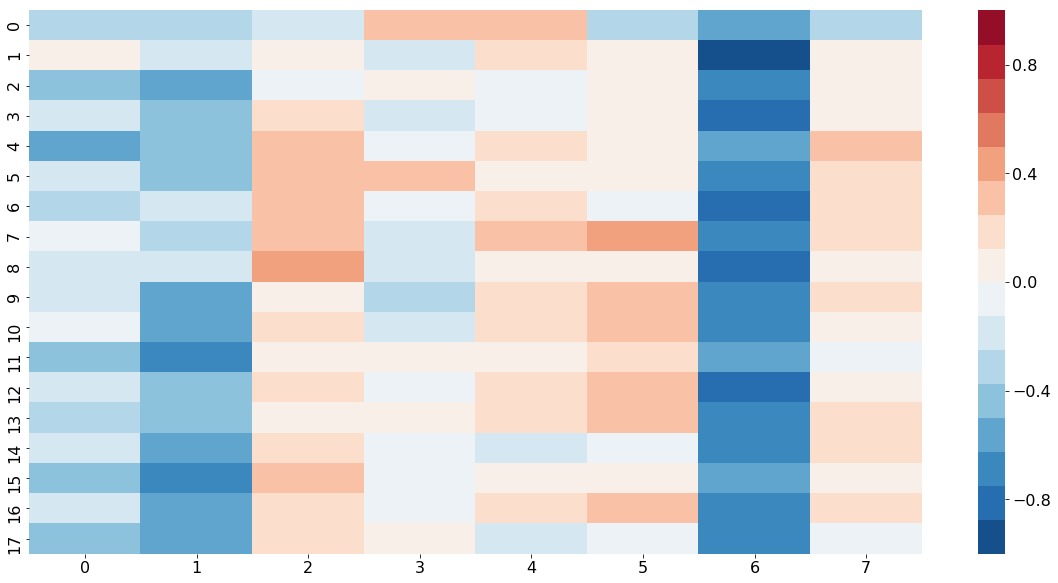

Sales 6 btw


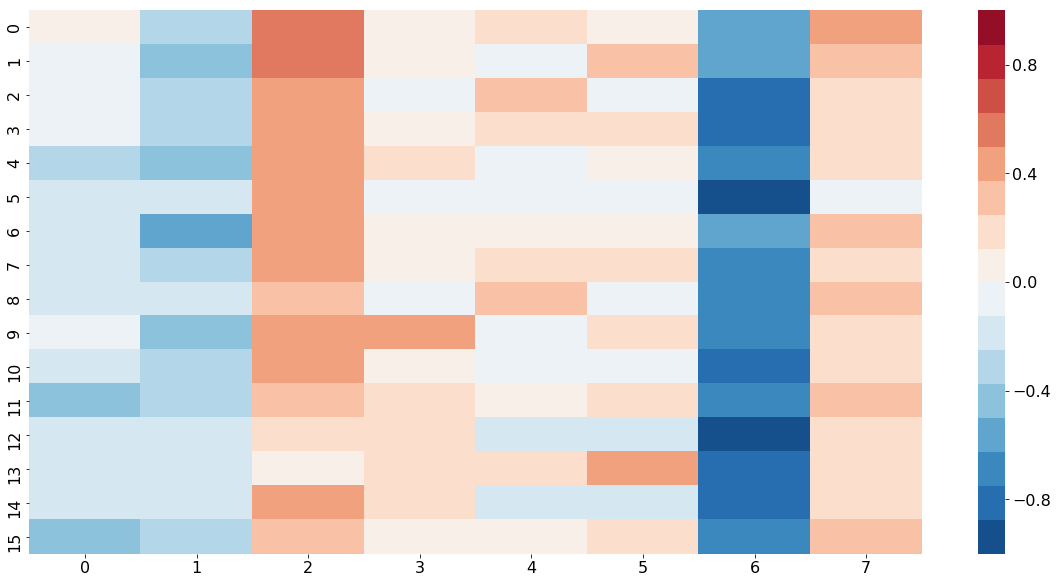

Tax disbursement
Not enough samples...


In [9]:
for name, group in res.groupby("FA_Name"):
    print(name)
    if group.shape[0] > 3:
        sns.heatmap(list(group["Emb"].values), vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 16))
        plt.show()
    else:
        print("Not enough samples...")

In [10]:
res2 = get_embs_TF(path_file="Simulation/FSN_Data.db", embed_size=8, num_steps=50000, walks_per_node=50, walk_length=20)

[(0, 66), (0, 27), (0, 9), (66, 0), (66, 27)]
Initialized
Average train loss at step  0 :  2.4131040573120117
Nearest to 93: 162, 66, 159,
Nearest to 79: 10, 98, 54,
Nearest to 2: 13, 14, 128,
Nearest to 150: 140, 29, 112,
Average train loss at step  1000 :  0.7498910451829434
Average train loss at step  2000 :  0.4778407782018185
Average train loss at step  3000 :  0.3875078389793634
Average train loss at step  4000 :  0.31624926718324425
Average train loss at step  5000 :  0.2825950905382633
Nearest to 93: 22, 152, 136,
Nearest to 79: 10, 30, 33,
Nearest to 2: 30, 112, 47,
Nearest to 150: 29, 9, 109,
Average train loss at step  6000 :  0.2683067495971918
Average train loss at step  7000 :  0.26317026234418156
Average train loss at step  8000 :  0.2558368648737669
Average train loss at step  9000 :  0.25742523135989903
Average train loss at step  10000 :  0.2545440375059843
Nearest to 93: 22, 152, 6,
Nearest to 79: 10, 30, 148,
Nearest to 2: 30, 112, 47,
Nearest to 150: 29, 109, 9,
Av

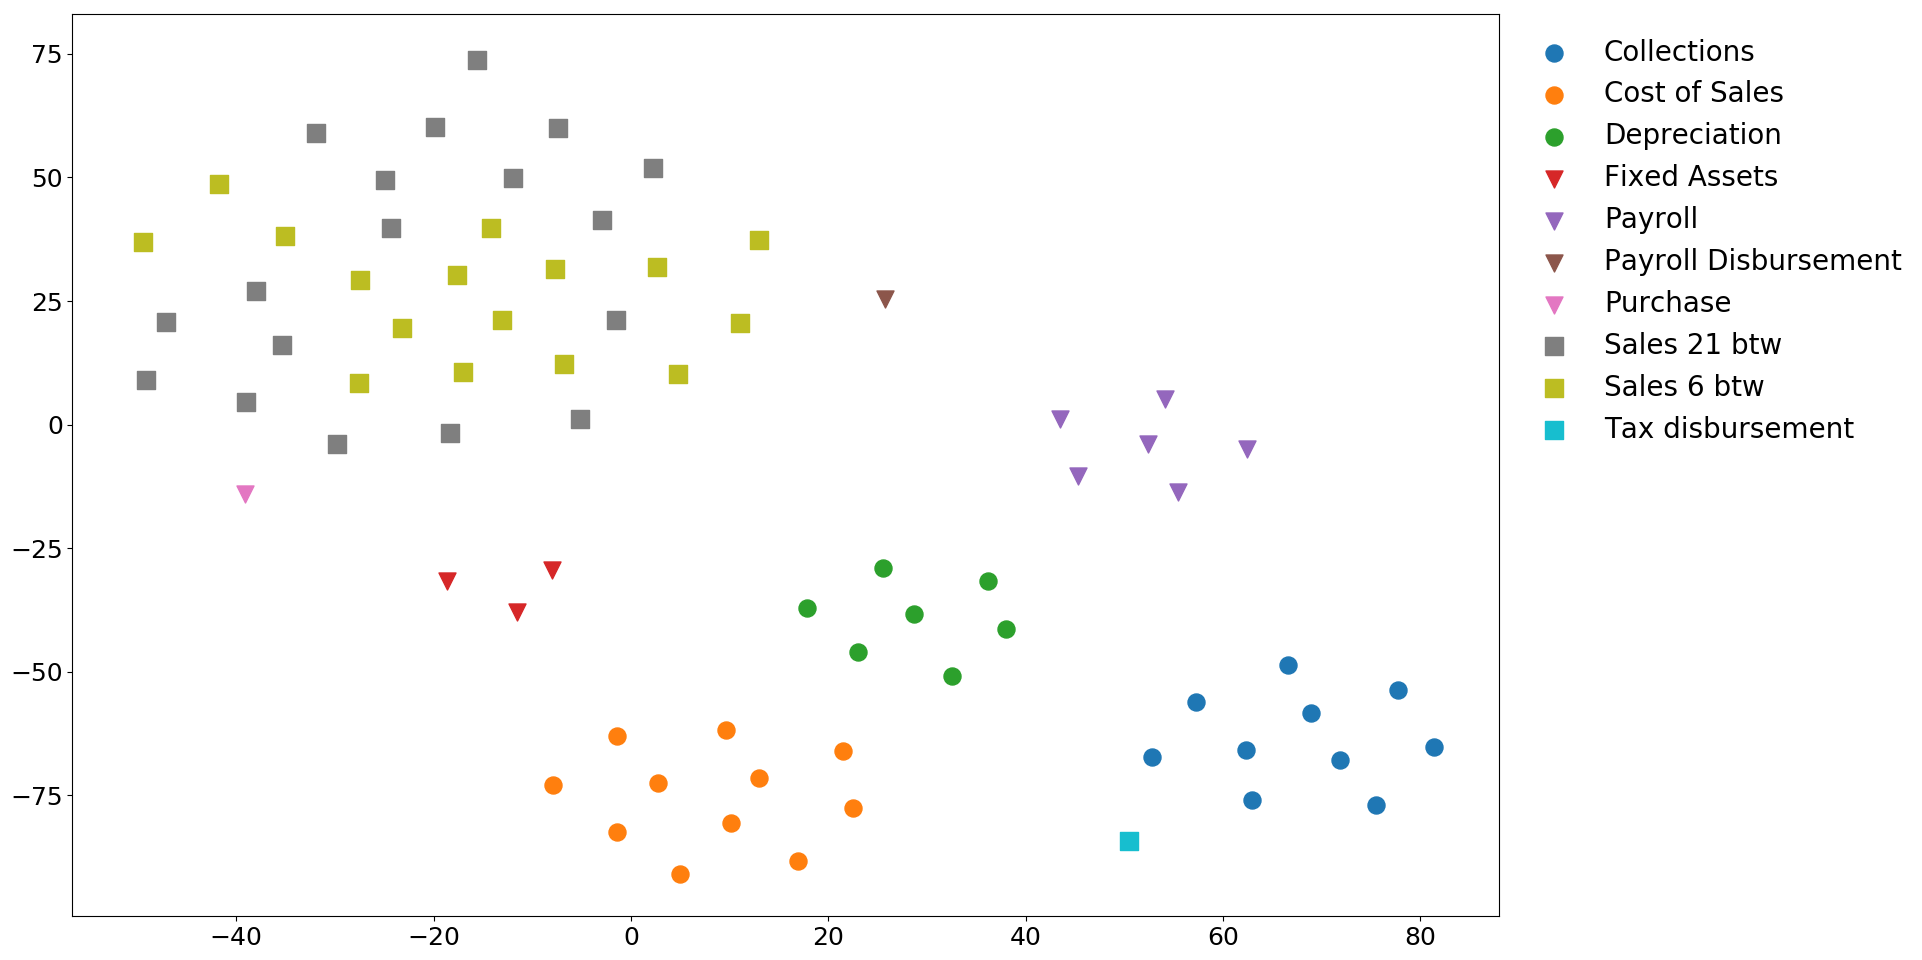

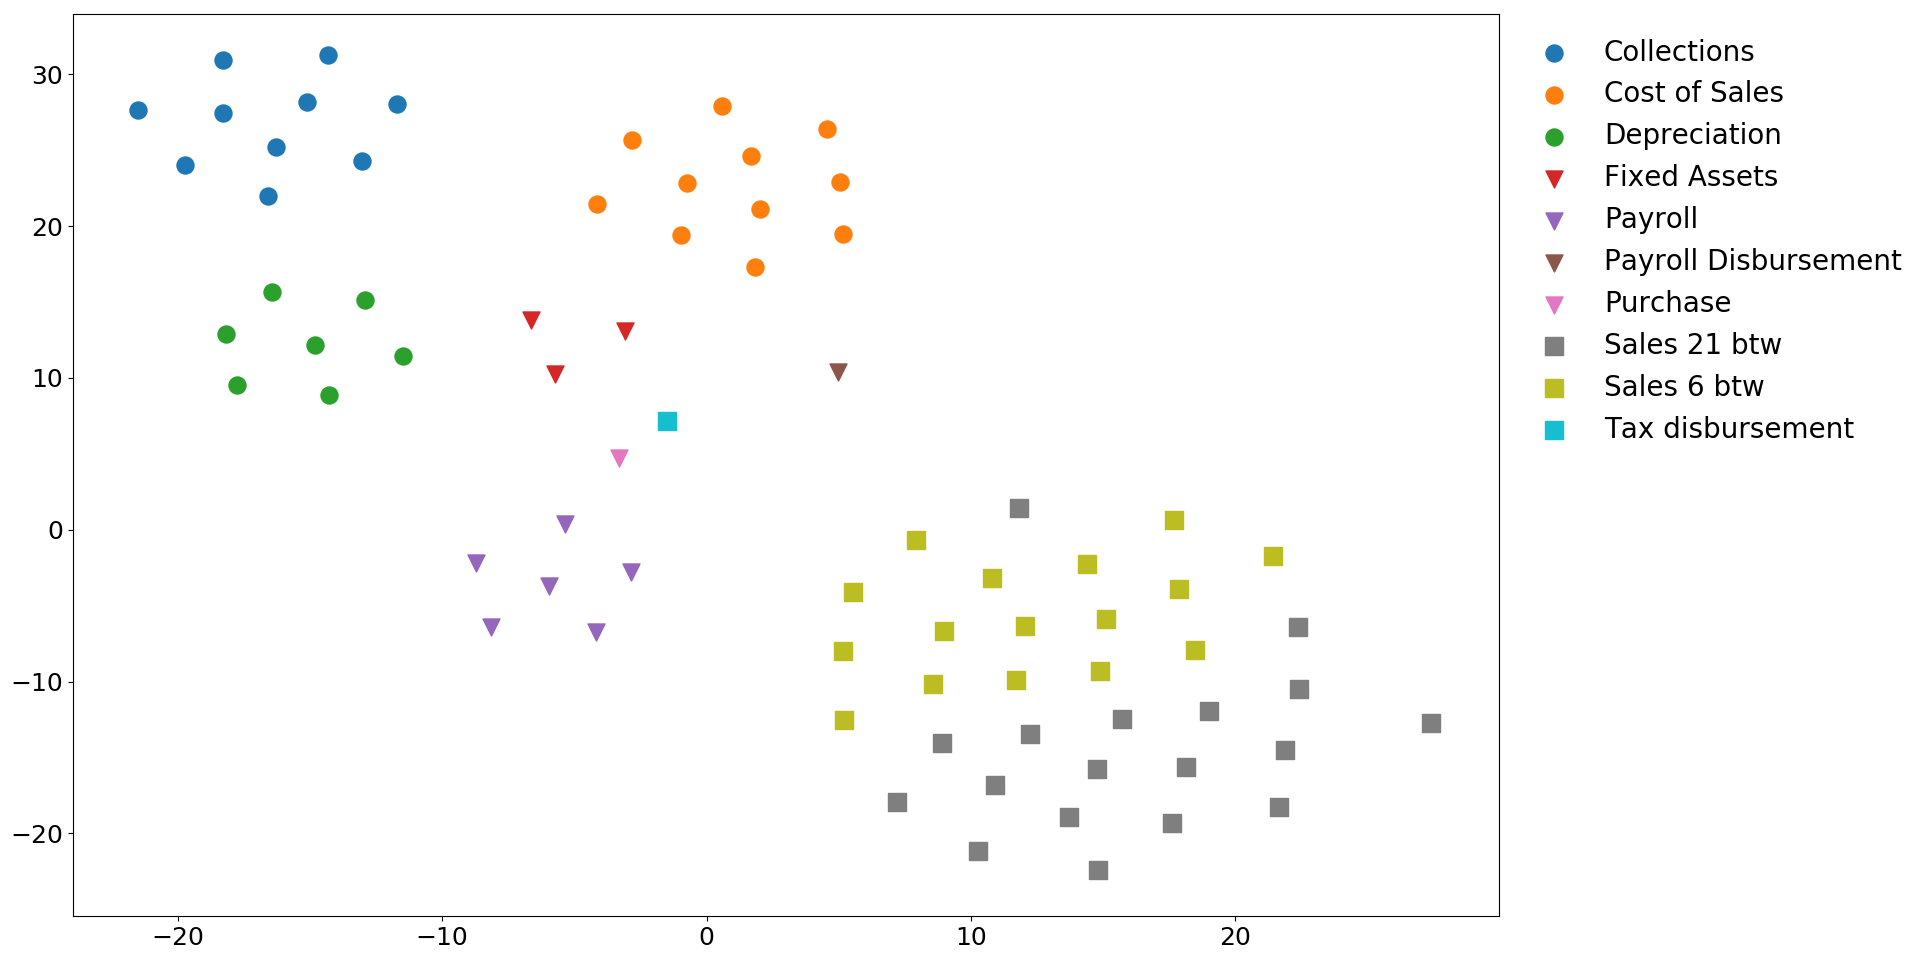

In [81]:
def plot_tSNE(fsn_embs, title="tSNE", rand_state=1, manual=False):
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    tsne = TSNE(random_state=rand_state)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs.iloc[:, 1])))
    embed_tsne = tsne.fit_transform(embdf)
    fsn_embs["x"] = pd.Series(embed_tsne[:, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:, 1])
    import seaborn as sns
    markers = ["o", "v", "s"]
    cur_m=0
    if manual:
        plt.clf()
        n_gr = 0
        for name, group in fsn_embs.groupby("FA_Name"):
            n_gr+=1
            if n_gr>3:
                cur_m = cur_m+1 if len(markers)-1>cur_m else 0
                n_gr=0
            plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], label=name)
#         sns.scatterplot(data=fsn_embs, x="x", y="y", hue="FA_Name", s=150)
        plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", frameon=False, markerscale=1)
    else:
        fg = sns.FacetGrid(data=fsn_embs, hue='FA_Name', aspect=1.61, height=6, legend_out=True)
        fg.map(pyplot.scatter, 'x', 'y')
        fg.add_legend()
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/" + title, dpi=140, pad_inches=0.01)
    plt.show()
    return fsn_embs
def set_font(s, reset=False):
    if reset:
        plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams["figure.figsize"] = [20,10]
#     plt.rcParams['font.family'] = 'serif'
#     plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rc('font', size=s)          # controls default text sizes
    plt.rc('axes', titlesize=s)     # fontsize of the axes title
    plt.rc('axes', labelsize=s)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=s-2)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=s-2)    # fontsize of the tick labels
    plt.rc('legend', fontsize=s)    # legend fontsize
    plt.rc('figure', titlesize=s)  # fontsize of the figure title

rand_seed = 2
set_font(20)
_ = plot_tSNE(res, "FastTrain10k", rand_seed, manual=True)
dd = plot_tSNE(res2, "LongTrain50k", rand_seed, manual=True)

## Clustering Init

In [53]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
res2[res2["FA_Name"]=="Sales 21 btw"].head(5)

,ID,Emb,FA_Name,x,y
0,1,"[0.41521674, 0.32345572, 0.357553, 0.6200953, -0.15125076, 0.24258587, 0.08962632, 0.34763697]",Sales 21 btw,27.398760,-12.732614
6,7,"[0.046694435, 0.23435505, -0.036985625, 0.7609663, 0.49037972, 0.2755795, -0.17775299, 0.12019738]",Sales 21 btw,14.760406,-15.772031
7,9,"[-0.08563909, 0.12582234, 0.13033538, 0.9178803, 0.28954807, 0.02970011, -0.1764592, -0.03853884]",Sales 21 btw,22.371382,-6.412063
9,11,"[-0.08110859, 0.23119168, 0.023138467, 0.66237986, 0.60545295, 0.34939608, -0.061914966, 0.090581775]",Sales 21 btw,14.818859,-22.417093
17,24,"[0.066771045, 0.15720688, 0.010882352, 0.7686608, 0.5464647, 0.25541016, -0.05340963, 0.11471411]",Sales 21 btw,18.133703,-15.646170


In [55]:
NUM_CL_MAX = 10
cl = pd.DataFrame(list(map(np.ravel, res2.iloc[:, 1])))
print("First row of Data: \n", cl.iloc[0].values)
cur_score = 0.0
cur_num_cls = 2
for cur_cl in range(2, NUM_CL_MAX):
    km = KMeans(n_clusters=cur_cl)
    predicted_labels = km.fit_predict(cl)
    silhouette_avg = silhouette_score(cl, predicted_labels)
    if silhouette_avg >= cur_score:
        cur_score = silhouette_avg
        cur_num_cl = cur_cl
print("Optimal number of clusters is = ", cur_num_cl,
          "The average silhouette_score is :", cur_score)

First row of Data: 
 [ 0.41521674  0.32345572  0.35755301  0.62009531 -0.15125076  0.24258587
  0.08962632  0.34763697]
Optimal number of clusters is =  7 The average silhouette_score is : 0.5435017145109018


In [73]:
def plot_clusters(fsn_embs, n_cl = 6, title="KMean", rand_state=1, manual=True):
    import os
    random.seed(rand_state)
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    tsne = TSNE(random_state=rand_state)
    embdf = pd.DataFrame(list(map(np.ravel, fsn_embs.iloc[:, 1])))
    #     Clustering stuff
    print("First row of Data: \n", embdf.iloc[0].values)
    km = KMeans(n_clusters=n_cl)
    predicted_labels = km.fit_predict(embdf)
    centroids = km.cluster_centers_
    silhouette_avg = silhouette_score(cl, predicted_labels)
    print("For n_clusters = ", n_cl,
              "The average silhouette_score is :", silhouette_avg)
#     TODO sync TSNE without clusters centers
    embdf = embdf.append(pd.DataFrame(centroids))
    embed_tsne = tsne.fit_transform(embdf)
    print(len(embed_tsne))
    fsn_embs["x"] = pd.Series(embed_tsne[:-n_cl, 0])
    fsn_embs["y"] = pd.Series(embed_tsne[:-n_cl, 1])
    import seaborn as sns
    markers = ["o", "v", "s"]
    cur_m=0
    if manual:
        plt.clf()
        n_gr = 0
        for name, group in fsn_embs.groupby("FA_Name"):
            n_gr+=1
            if n_gr>10:
                cur_m = cur_m+1 if len(markers)-1>cur_m else 0
                n_gr=0
            plt.scatter(group["x"].values, group["y"].values, s=150, marker=markers[cur_m], label=name)
#         sns.scatterplot(data=fsn_embs, x="x", y="y", hue="FA_Name", s=150)
        plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", frameon=False, markerscale=2)
    else:
        fg = sns.FacetGrid(data=fsn_embs, hue='FA_Name', aspect=1.61, height=6, legend_out=True)
        fg.map(pyplot.scatter, 'x', 'y')
        fg.add_legend()
    plt.scatter(embed_tsne[-n_cl:, 0], embed_tsne[-n_cl:, 1], marker='*', s=300, c='r', label='centroid')
    plt.show()
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/" + title, dpi=140, pad_inches=0.01)
    return fsn_embs

## !Graphs differ because tSNE use all datatpoint during transformaiton (in our case we add clusters centers)

First row of Data: 
 [ 0.41521674  0.32345572  0.35755301  0.62009531 -0.15125076  0.24258587
  0.08962632  0.34763697]
For n_clusters =  7 The average silhouette_score is : 0.5435017145109018
81


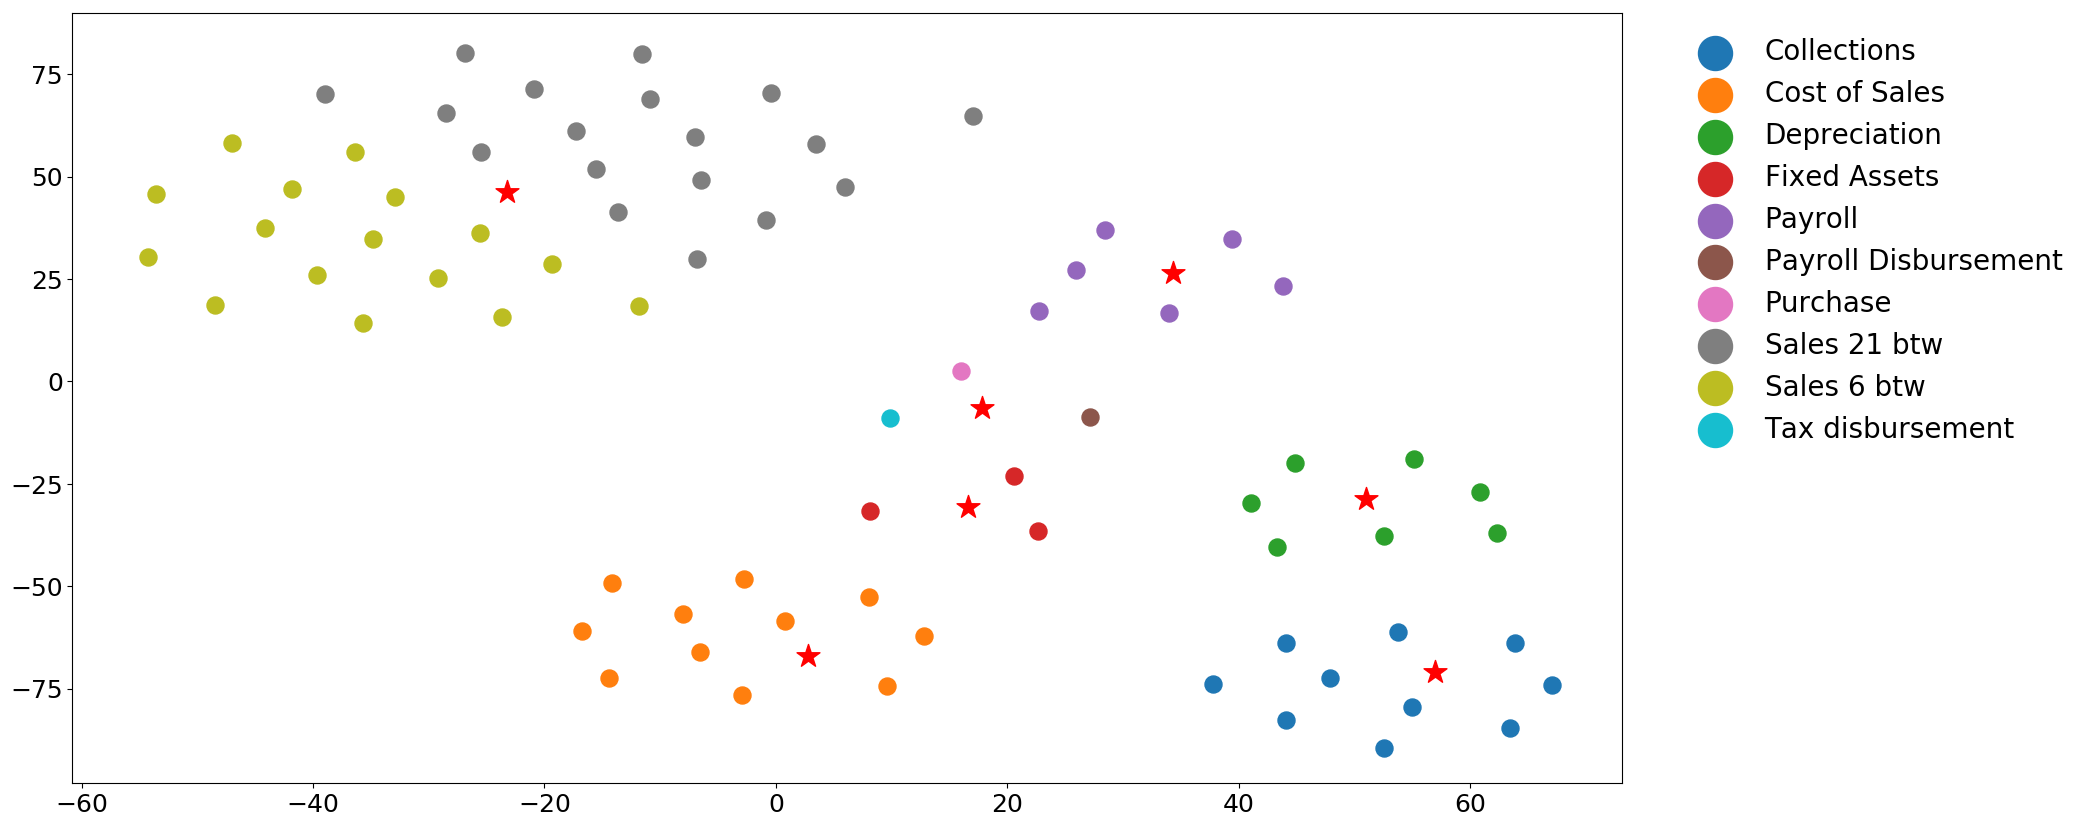

<Figure size 2000x1000 with 0 Axes>

In [80]:
_ = plot_clusters(res2, 7, rand_state=24)

In [ ]:
from sklearn.mixture import GaussianMixture